# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Instructions

Setup matplotlib to work in Jupyter notebook.

There are several fields in combined that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score.

You can find a list of the fields in the survey_fields variable in the notebook.

Consult the data dictionary that is part of the zip file that you can download here.

Are there any surprising correlations that you found?

Write up your results in a markdown cell.

# Plotting and analysing survey related correlations

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

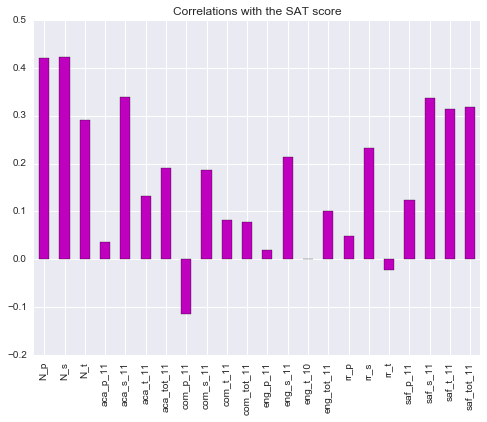

In [12]:
survey = survey_fields[:]
survey.remove("DBN")
corr_survey = correlations.loc[survey]
corr_survey.sort_index(inplace=True)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
corr_survey.plot(kind='bar',color='m')
plt.title("Correlations with the SAT score")
plt.show()

1) Most of the terms seem to show a positive correlation, except the comp_p_11, which is the communication score based on the parent's responses

2) The highest correlation is with the N_s and the N_p with N_t's correlation in between. Meaning, there is a higher correlation with the number of student and parent respondents than with the number of teacher respondents. This could mean that the schools where the parents and students' opinions are taken into account show a better SAT score. 

3) What is interesting is the difference in correlation between the actual number of responses and the response rates.
- N_s is higher than rr_s (both are positive)
- N_p is higher than rr_p (both are positive)
- N_t is higher than rr_t (rr_t is negative)

4) Safety statistics seem to have a high correlation as well (saf_p_11, saf_s_11, saf_t_11, saf_tot_11)

# Safety score analysis

Safety statistics seem to have a high correlation with the sat_scores. We can delve further into this. 

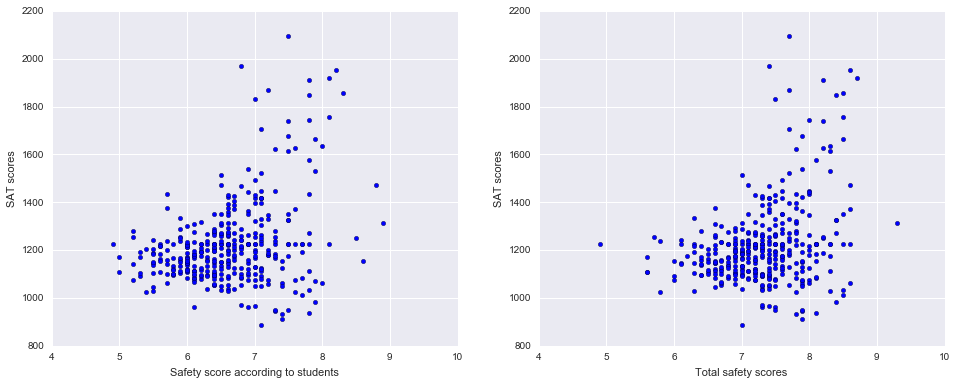

In [13]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(combined["saf_s_11"],combined["sat_score"])
ax1.set(xlabel="Safety score according to students",ylabel="SAT scores")

ax2.scatter(combined["saf_tot_11"],combined["sat_score"])
ax2.set(xlabel="Total safety scores",ylabel="SAT scores")

plt.show()

* There seems to be a tight cluster in the low safety score - low sat_score range with an ambiguous trend 
* As the score increases, the sat_scores seem to show a general upward trend, albiet in different rates (as can be concluded from the branching after the cluster)

In [14]:
for i in combined.columns:
    print(i)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF STUDENTS / SEATS FILLED
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percen

In [15]:
import numpy as np

In [16]:
# computing average safety scores for each district

safety = combined.groupby("school_dist").agg(np.mean)[["saf_tot_11","lat","lon"]]
safety

,saf_tot_11,lat,lon
school_dist,,,
01,7.433333,40.719022,-73.982377
02,7.520833,40.739699,-73.991386
03,7.233333,40.781574,-73.977370
04,7.714286,40.793449,-73.943215
05,7.085714,40.817077,-73.949251
06,7.660000,40.848970,-73.932502
07,7.392308,40.816815,-73.919971
08,7.218182,40.823803,-73.866087
09,7.365000,40.836349,-73.906240


In [17]:
from mpl_toolkits.basemap import Basemap

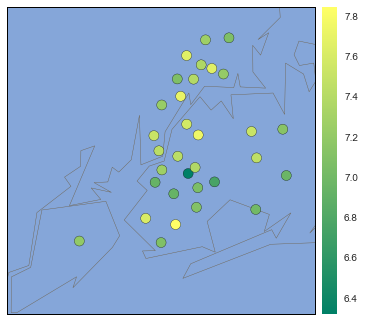

In [18]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#00FFFF', linewidth=.4)

longitudes = safety["lon"].tolist()
latitudes = safety["lat"].tolist()
m.scatter(longitudes, latitudes, s=100, zorder=2, latlon=True,c=safety["saf_tot_11"],cmap="summer")

m.colorbar()
plt.show()

![title](Images/boroughs.jpg)

When we compare the safety map with the above map of newyork boroughs, we can see that -

    1) Districts in manhattan seem to have a better safety score owing to a lighter dot on the map
    2) Districts in Brooklyn and Queens to have a few darker dots implying lower safety scores in the schools in that district

# Race and SAT scores

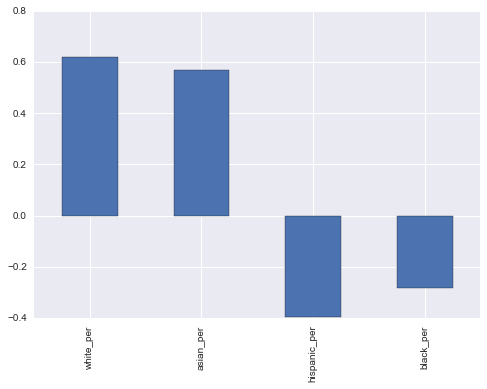

In [23]:
race_columns = ["white_per","asian_per","hispanic_per","black_per"]
race_corr = correlations.loc[race_columns]
race_corr.plot(kind='bar')

Asian and white percentages have a positive correlation 

Hispanic and Black percentages have a negative correlation

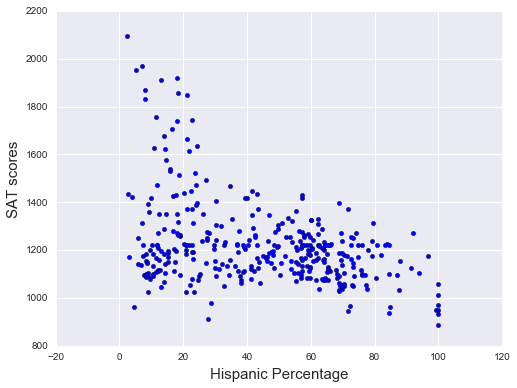

In [29]:
# plotting hispanic_per versus sat_score 

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(combined["hispanic_per"],combined["sat_score"])
plt.xlabel("Hispanic Percentage",fontsize=15)
plt.ylabel("SAT scores",fontsize=15)
plt.show()

There is clearly a negative correlation between the SAT scores and Hispanic percentage in that area.

But we can't conclude that 'low' hispanic percentage is surely associated with high scores since a cluster of low hispanic percentages have low scores as well. We can go ahead and assess that further

In [33]:
# researching schools with hispanic percentage of 95% or greater

combined[combined["hispanic_per"] > 95][["DBN","SCHOOL NAME","hispanic_per","sat_score"]]

,DBN,SCHOOL NAME,hispanic_per,sat_score
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,99.8,1058.0
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7,1174.0
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8,1014.0
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4,951.0
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8,934.0
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8,970.0
253,19K583,MULTICULTURAL HIGH SCHOOL,99.8,887.0
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0,951.0


Checking this link to find out more about the schools that got shortlisted above -

http://insideschools.org/


These are some observations - 
1) 3 of the schools belong to Manhattan,  3 schools belong to Bronx, 1 school belongs to Brooklyn and 1 school belongs to Queens
    There doesn't seem to be one particular borough that dominates this list
    
2) All the schools seem to cater to recent immigrants with very less english proficiency. 

3) Below, i listed the incoming students proficiency score given on the website, with the city average being 2.38. Almost all of the schools seem to have a below average score.

- Manhattan Bridges -> incoming students proficiency = 2.19
- Washington heights -> 2.44 
- gregorio -> 1.90
- academy for language ->1.94
- international school for liberal arts -> 2.21
- pan american international high school at monroe -> 1.81
- multicultural high school -> 1.86
- pan american international high school -> 1.87


In [34]:
# researching schools with less than 10% hispanic population and SAT score greater than 1800

combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)][["DBN","SCHOOL NAME","hispanic_per","sat_score"]]

,DBN,SCHOOL NAME,hispanic_per,sat_score
37,02M475,STUYVESANT HIGH SCHOOL,2.4,2096.0
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,7.2,1969.0
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,1833.0
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,1868.0
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.0


Observations about these schools - 

1) High asian percentage - almost all the schools except staten island technical high school have more than 60% asian population

2) The academics are described as rigorous and high pressure

3) It looks like the focus is more on Sciences than on Arts


# Gender and SAT scores

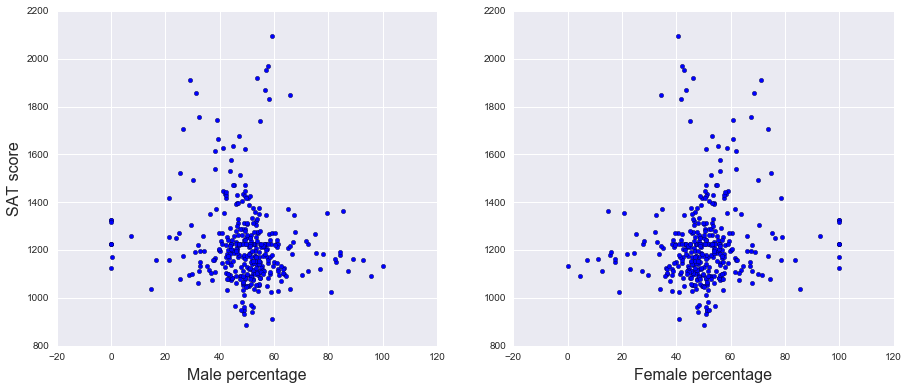

In [42]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(combined["male_per"],combined["sat_score"])
ax1.set_xlabel("Male percentage",fontsize=16)
ax1.set_ylabel("SAT score",fontsize=16)

ax2.scatter(combined["female_per"],combined["sat_score"])
ax2.set_xlabel("Female percentage",fontsize=16)


plt.show()

There doesn't seem to be a solid positive or negative correlation with either the male or female percentages

As for the female percentage, we can see that there is a tight cluster at the center at around 40-50% female population and <1400 sat score. 

In [44]:
# investigating high female percentage and high sat score schools

combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)][["DBN","SCHOOL NAME","female_per","male_per","sat_score"]]

,DBN,SCHOOL NAME,female_per,male_per,sat_score
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,68.7,31.3,1856.0
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,32.5,1758.0
60,03M479,BEACON HIGH SCHOOL,61.0,39.0,1744.0
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,26.4,1707.0
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,71.1,28.9,1910.0


These were some of my observations on the above schools - 

1) They are higher on white percentage (except townsend, which has higher asian percentage) 

2) Admissions seem to be selective 

3) Focus is more on arts than sciences

# AP test takers and SAT scores

In [45]:
# calculating percentage of total students that took the AP test

combined["ap_per"] = (combined["AP Test Takers "]/combined["total_enrollment"])*100

combined["ap_per"].head()

0    30.575556
1     9.898477
2     3.177258
3    35.157724
4    15.809051
Name: ap_per, dtype: float64

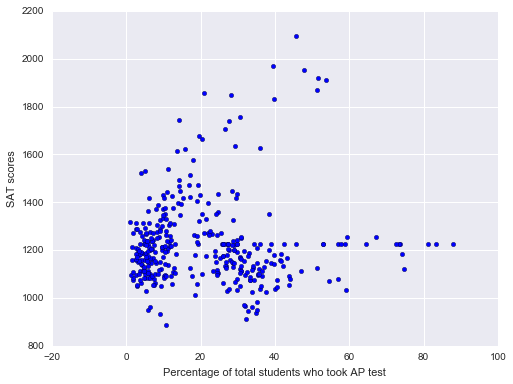

In [48]:
# plotting the ap_per versus the sat scores

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x=combined["ap_per"],y=combined["sat_score"])
ax.set(xlabel="Percentage of total students who took AP test",ylabel="SAT scores")
plt.show()

The results clearly don't seem to follow a set pattern, but there are some interesting observations - 

1) After the initial initial cluster from percentages 0-20, the data seem to be branching two ways

2) One branch seems to be positively correlated and the other one seems to be following a more constant pattern after about 40%

We can research this a little further, especially the data points beyond 40% of AP test takers

In [90]:
# first researching  the data points which have greater than 40% AP test takers and greater than 1800 score

columns_of_interest = ["DBN","SCHOOL NAME","female_per","white_per","asian_per","black_per","hispanic_per","sat_score"]
high_per_high_score = combined[(combined["ap_per"] > 40) & (combined["sat_score"] > 1800)][columns_of_interest]
high_per_high_score["white_asian"] = high_per_high_score["white_per"] + high_per_high_score["asian_per"]
high_per_high_score["black_hispanic"] = high_per_high_score["black_per"] + high_per_high_score["hispanic_per"]
high_per_high_score

,DBN,SCHOOL NAME,female_per,white_per,asian_per,black_per,hispanic_per,sat_score,white_asian,black_hispanic
37,02M475,STUYVESANT HIGH SCHOOL,40.7,23.7,72.1,1.2,2.4,2096.0,95.8,3.6
155,10X696,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,46.2,53.8,16.7,10.6,18.0,1920.0,70.5,28.6
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,71.1,24.6,55.5,5.9,12.9,1910.0,80.1,18.8
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,43.5,6.7,74.4,10.5,7.9,1868.0,81.1,18.4
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,43.0,61.3,31.8,1.1,5.3,1953.0,93.1,6.4


Just checking the racial profile of this data slice, we can say that either the schools are 

1) Asian or white majority
2) Black or hispanic majority

Calculated asian+white and black+hispanic percentages to try and explore this hunch

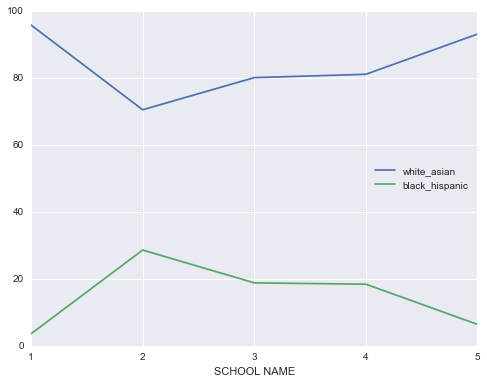

In [96]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

high_per_high_score[["SCHOOL NAME","white_asian"]].set_index("SCHOOL NAME").plot(ax=ax)
high_per_high_score[["SCHOOL NAME","black_hispanic"]].set_index("SCHOOL NAME").plot(ax=ax)

ax.set_xticks(np.arange(0,len(high_per_high_score)))
ax.set_xticklabels(np.arange(1,(len(high_per_high_score)+1)))


plt.show()

There is defintely a clear asian_white majority in this slice 

In [97]:
# now researching the data points wihch have greater than 40% AP test takers but less than 1800 score

high_per_low_score = combined[(combined["ap_per"] > 40) & (combined["sat_score"] < 1800)][columns_of_interest]
high_per_low_score["white_asian"] = high_per_low_score["white_per"] + high_per_low_score["asian_per"]
high_per_low_score["black_hispanic"] = high_per_low_score["black_per"] + high_per_low_score["hispanic_per"]
high_per_low_score.head()

,DBN,SCHOOL NAME,female_per,white_per,asian_per,black_per,hispanic_per,sat_score,white_asian,black_hispanic
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,57.5,6.3,1.7,32.2,59.2,1182.000000,8.0,91.4
19,02M393,BUSINESS OF SPORTS SCHOOL,27.6,4.3,1.6,35.5,57.2,1223.438806,5.9,92.7
20,02M399,THE HIGH SCHOOL FOR LANGUAGE AND DIPLOMACY,52.0,5.3,44.3,15.6,32.8,1223.438806,49.6,48.4
31,02M427,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,45.1,1.1,6.3,8.0,84.6,1223.438806,7.4,92.6
32,02M437,HUDSON HIGH SCHOOL OF LEARNING TECHNOLOGIES,39.4,6.6,5.8,23.5,62.4,1223.438806,12.4,85.9


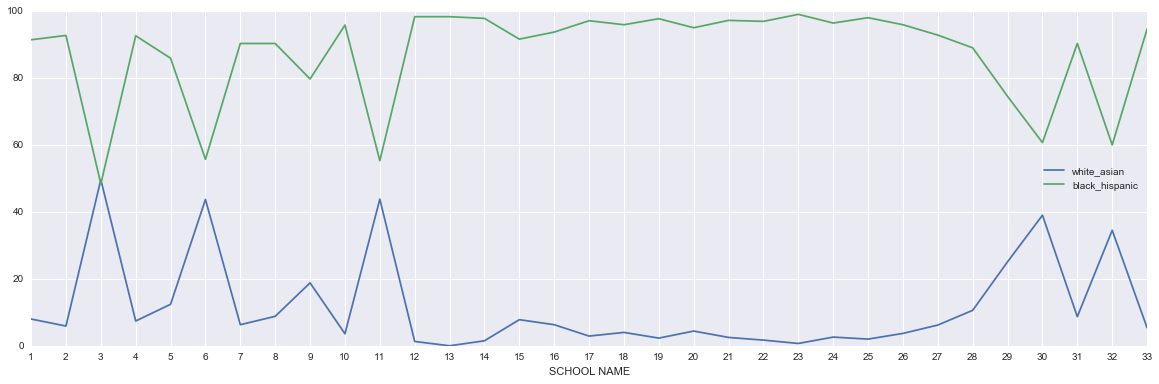

In [98]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)

high_per_low_score[["SCHOOL NAME","white_asian"]].set_index("SCHOOL NAME").plot(ax=ax)
high_per_low_score[["SCHOOL NAME","black_hispanic"]].set_index("SCHOOL NAME").plot(ax=ax)

ax.set_xticks(np.arange(0,len(high_per_low_score)))
ax.set_xticklabels(np.arange(1,(len(high_per_low_score)+1)))


plt.show()

The hunch seems to be sort of proving true. 

Here in this slice of the dataset, there is a clear black_hispanic majority and asian_white minority